Análise: distribuição dos modelos de urna por local de votação.
--------------------------------------------------------------

In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Extraído do arquivo modelourna_numerointerno.csv disponibilizado pelo TSE
MODELOS = {
    # ano:  [inicial, final]
    "2009": [ 999500,  1220500 ],
    "2010": [ 1220501, 1345500 ],
    "2011": [ 1368501, 1650000 ],
    "2013": [ 1650001, 1701000 ],
    "2015": [ 1750000, 1950000 ],
    "2020": [ 2000000, 2250000 ],
}

ESTADOS = [
    "RS","SC","PR",
    "SP","RJ","MG","ES",
    "MS","MT","GO","DF",
    "BA","SE","AL","PE","PB","RN","CE","PI","MA",
    "TO","PA","RO","AC","AM","AP","RR",
    "ZZ"
]

COLUNAS = [
    "SG_UF","NR_ZONA","NR_SECAO","DS_CARGO_PERGUNTA","NR_LOCAL_VOTACAO","NR_URNA_EFETIVADA","NM_VOTAVEL","QT_APTOS","QT_VOTOS",
]

def modelo_by_urna(urna):
    for modelo, (inicial, final)  in MODELOS.items():
        if inicial <= urna <= final:
            return modelo
    return None


Realizamos a leitura dos arquivos estado-por-estado, removendo as linhas que
não interessam (i.e. eleição pra Governador), e adicionando uma coluna com
o modelo da urna utilizado.

In [195]:
all_dfs = []

for estado in ESTADOS:
    nome_arquivo = f"data/original/bweb_2t_{estado}_311020221535.csv"
    arquivo = pd.read_csv(nome_arquivo, sep=";", encoding="iso-8859-1")
    dfe = pd.DataFrame(arquivo, columns=COLUNAS)
    dfe = dfe[dfe.DS_CARGO_PERGUNTA == "Presidente"]
    dfe = dfe.assign(SY_MODELO_URNA=dfe.NR_URNA_EFETIVADA.apply(modelo_by_urna))
    dfe = dfe.assign(SY_COUNT=1)
    dfe = dfe.assign(SY_LOCAL_VOTACAO_CHAVE=dfe.SG_UF + "-" + dfe.NR_ZONA.astype(str) + "-" + dfe.NR_LOCAL_VOTACAO.astype(str))
    all_dfs.append(dfe)

df = pd.concat(all_dfs)

df

,SG_UF,NR_ZONA,NR_SECAO,DS_CARGO_PERGUNTA,NR_LOCAL_VOTACAO,NR_URNA_EFETIVADA,NM_VOTAVEL,QT_APTOS,QT_VOTOS,SY_MODELO_URNA,SY_COUNT,SY_LOCAL_VOTACAO_CHAVE
0,RS,1,1,Presidente,1422,2215453,Branco,355,10,2020,1,RS-1-1422
1,RS,1,1,Presidente,1422,2215453,JAIR BOLSONARO,355,108,2020,1,RS-1-1422
2,RS,1,1,Presidente,1422,2215453,Nulo,355,9,2020,1,RS-1-1422
3,RS,1,1,Presidente,1422,2215453,LULA,355,155,2020,1,RS-1-1422
8,RS,1,2,Presidente,1325,2213088,Nulo,358,7,2020,1,RS-1-1325
...,...,...,...,...,...,...,...,...,...,...,...,...
3963,ZZ,1,3390,Presidente,1031,1023396,JAIR BOLSONARO,639,115,2009,1,ZZ-1-1031
3964,ZZ,1,3394,Presidente,1031,1019971,LULA,696,270,2009,1,ZZ-1-1031
3965,ZZ,1,3394,Presidente,1031,1019971,JAIR BOLSONARO,696,110,2009,1,ZZ-1-1031
3966,ZZ,1,3394,Presidente,1031,1019971,Nulo,696,1,2009,1,ZZ-1-1031


Agora, pivotamos os dados, usando como chave a urna e cada candidato possível como uma
nova coluna. Isso permitirá outras análises de forma simplificada, mas a rigor não era
necessário para analisar os modelos de urna por local de votação

In [196]:
# cs = colapsado por seção

cs = df.pivot_table(
    columns="NM_VOTAVEL",
    values="QT_VOTOS",
    aggfunc=np.sum,
    fill_value=0,
    index=[
        df.SG_UF, df.NR_ZONA, df.NR_SECAO, df.SY_MODELO_URNA,
        df.NR_LOCAL_VOTACAO, df.NR_URNA_EFETIVADA, df.SY_LOCAL_VOTACAO_CHAVE], 
).reset_index().rename_axis(None, axis=1)

cs.to_csv("secao_colapsado.csv")

cs


,SG_UF,NR_ZONA,NR_SECAO,SY_MODELO_URNA,NR_LOCAL_VOTACAO,NR_URNA_EFETIVADA,SY_LOCAL_VOTACAO_CHAVE,Branco,JAIR BOLSONARO,LULA,Nulo
0,AC,1,3,2020,1279,2046404,AC-1-1279,2,96,48,1
1,AC,1,4,2020,1139,2048249,AC-1-1139,2,167,83,7
2,AC,1,5,2020,1031,2048064,AC-1-1031,3,183,72,2
3,AC,1,6,2020,1031,2043747,AC-1-1031,1,168,72,4
4,AC,1,7,2020,2321,2048283,AC-1-2321,0,192,83,5
...,...,...,...,...,...,...,...,...,...,...,...
472022,ZZ,1,3363,2009,1031,1010675,ZZ-1-1031,6,132,363,1
472023,ZZ,1,3374,2015,1031,1815999,ZZ-1-1031,6,98,165,3
472024,ZZ,1,3386,2009,1031,1017187,ZZ-1-1031,0,83,245,3
472025,ZZ,1,3390,2009,1031,1023396,ZZ-1-1031,0,115,217,6


Aqui pivotamos novamente os dados, agora usando o _local de votação_ como chave, e o
número de urnas de cada modelo naquele local de votação como colunas. O "local de
votação", na terminologia usada pelo TSE, é cada endereço distinto que pode ser
informado para os eleitores quando estes consultam o local de votação. Tipicamente,
é um colégio ou algum outro local de grande porte.

Também adicionamos uma nova coluna contando o _número de modelos distintos_ que foi
utilizado em cada local de votação.

Por exemplo, se um dado local de votação tinha 25 urnas, das quais 20 eram modelo
2015 e 5 eram modelo 2013, a linha desse local de votação conterá:

```
UF  ZONA   LOCAL  2009  2010  2011  2013  2015  2020  SY_MODELOS_DISTINTOS
UU   12     345     0     0     0    5     20     0            2
```



In [197]:
# mulv = modelo urna x local de votação

mulv = df.pivot_table(
    columns="SY_MODELO_URNA",
    values="SY_COUNT",
    aggfunc=np.sum,
    fill_value=0,
    index=[df.SG_UF, df.NR_ZONA, df.NR_LOCAL_VOTACAO, df.SY_LOCAL_VOTACAO_CHAVE]
)
mulv["SY_MODELOS_DISTINTOS"] = mulv.astype(bool).sum(axis=1)
mulv = mulv.reset_index().rename_axis(None, axis=1)
mulv.to_csv("urnas_por_local_votacao.csv")

mulv

,SG_UF,NR_ZONA,NR_LOCAL_VOTACAO,SY_LOCAL_VOTACAO_CHAVE,2009,2010,2011,2013,2015,2020,SY_MODELOS_DISTINTOS
0,AC,1,1015,AC-1-1015,0,0,0,0,26,0,1
1,AC,1,1023,AC-1-1023,0,0,0,0,23,0,1
2,AC,1,1031,AC-1-1031,0,0,0,0,25,24,2
3,AC,1,1040,AC-1-1040,0,0,0,0,4,0,1
4,AC,1,1058,AC-1-1058,0,0,0,0,0,4,1
...,...,...,...,...,...,...,...,...,...,...,...
75401,ZZ,1,1104,ZZ-1-1104,8,0,0,0,0,0,1
75402,ZZ,1,1236,ZZ-1-1236,52,8,0,0,4,0,3
75403,ZZ,1,1244,ZZ-1-1244,8,0,0,0,0,0,1
75404,ZZ,1,1287,ZZ-1-1287,4,4,0,0,0,0,2


Por fim, criamos um conjunto de gráficos de histograma, um para cada modelo de urna,
indicando a distribuição do _número de modelos de urnas distintas_ em locais de votação
onde pelo menos uma urna do modelo esteve presente.

Em outras palavras, se um determinado local de votação tinha apenas urnas do modelo 2010,
2011 e 2013, este local de votação estará "contribuindo" na barra `3` nos gráficos 2010, 2011
e 2013 abaixo.

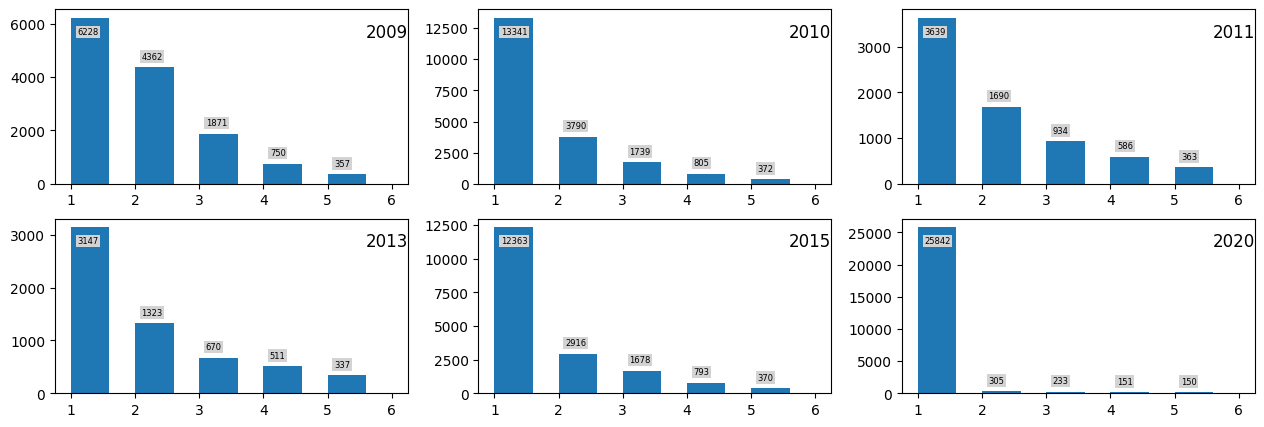

In [198]:


fig, axs = plt.subplots(2,3)
plt.rcParams['axes.titlepad'] = -20
plt.rcParams['axes.titley'] = 1
plt.subplots_adjust(bottom=0.1, right=2, top=0.9)

for index, modelo in enumerate(MODELOS):
    ax = axs[index // 3, index % 3]
    counts, bins, patches = ax.hist(mulv[mulv[modelo] > 0].SY_MODELOS_DISTINTOS, bins=5, width=0.6)
    maximum = max(*counts)
    for bin, count in zip(bins, counts):
        y = count + maximum * 0.05 if count < maximum * 0.95 else count - maximum * 0.1
        ax.text(bin + 0.1, y, str(int(count)), fontsize=6, bbox=dict(boxstyle="square,pad=0.2", fc="lightgray", ec="none"))
    ax.grid(False)
    ax.set_title(modelo, loc="right")


Com estes gráficos, podemos observar uma coisa interessante: as urnas modelo 2020
_muito raramente_ foram "misturadas" com outras urnas em um mesmo local de votação.

Isso por si só explica a aparente "distorção" onde essa urna estaria com resultados
radicalmente diferentes pois ela seria "infraudável": a distribuição das urnas
_não foi uniforme_. Ora, se a distribuição não é uniforme, não cabe aplicar testes
estatísticos cuja conclusão está lastreada na uniformidade.

/tmp/ipykernel_102067/1276708149.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  lhu2020 = mulv[mulv["2020"] > 0][mulv.SY_MODELOS_DISTINTOS > 1]
/tmp/ipykernel_102067/1276708149.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = cs.loc[cs.SY_LOCAL_VOTACAO_CHAVE.isin(lhu2020)][cs.SY_MODELO_URNA == modelo]


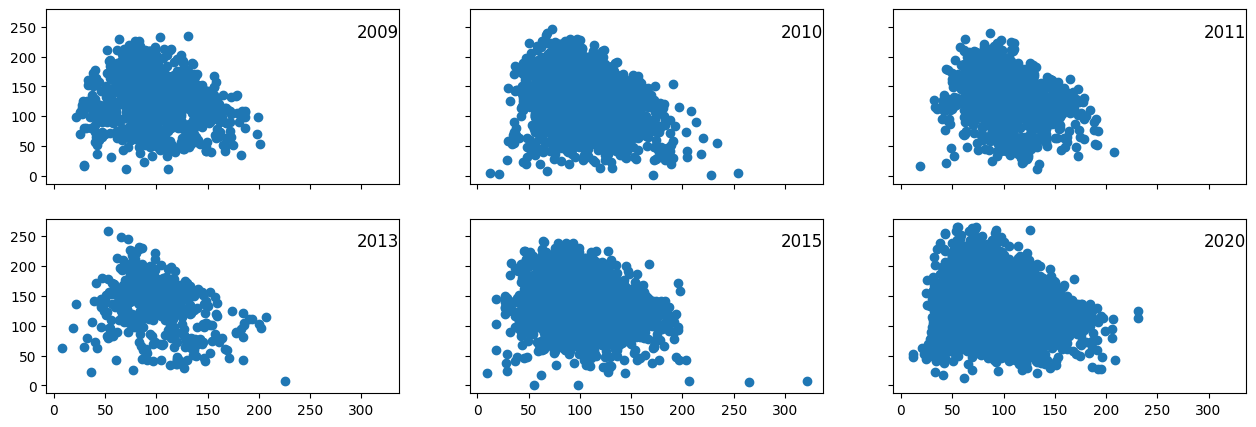

In [199]:
# lhu2020 = locais heterogeneos com urna 2020
lhu2020 = mulv[mulv["2020"] > 0][mulv.SY_MODELOS_DISTINTOS > 1]
lhu2020 = lhu2020.SY_LOCAL_VOTACAO_CHAVE.values

fig, axs = plt.subplots(2,3, sharex=True, sharey=True)
plt.rcParams['axes.titlepad'] = -20
plt.rcParams['axes.titley'] = 1
plt.subplots_adjust(bottom=0.1, right=2, top=0.9)

for index, modelo in enumerate(MODELOS):
    ax = axs[index // 3, index % 3]
    data = cs.loc[cs.SY_LOCAL_VOTACAO_CHAVE.isin(lhu2020)][cs.SY_MODELO_URNA == modelo]
    ax.scatter(data["LULA"], data["JAIR BOLSONARO"])
    ax.grid(False)
    ax.set_title(modelo, loc="right")

